# Project 3 S-box nonlinearity optimization using evolutionary methods
## Łukasz Andryszewski
### 151930
## Adam Korba
### 151962

In [63]:
import numpy as np
from sympy import fwht
import os
from itertools import combinations
import random
from deap import base, creator, tools, algorithms
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

np.random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# 1. Represent S-boxes as permutations of 0…255 and implement checks
We represent S-boxes as numpy arrays of 256 integers.
We implement a check to ensure the S-box is a valid permutation.

In [64]:
def byte2bit(_in: np.array):
    assert _in.dtype == np.uint8
    return np.unpackbits(_in)

def bit2byte(_in: np.array):
    assert _in.dtype == np.uint8
    return np.packbits(_in)

def random_input():
    return byte2bit(np.random.randint(0,256,dtype=np.uint8))

def random_sbox():
    return np.random.permutation(256)

def get_bool_func(sbox: np.array, j=0):
    assert 0 <= j <= 7
    bit = 1 << j # take jth bit
    bool_func_arr = np.bitwise_and(sbox,bit) # take the significant bit of each sbox
    bool_func_arr = np.right_shift(bool_func_arr,j) # right shift to get boolean array
    return bool_func_arr

In [65]:
np.right_shift(2,1)

np.int64(1)

In [66]:
bit2byte(byte2bit(np.array([23,12],dtype=np.uint8)))

array([23, 12], dtype=uint8)

In [67]:
a = random_sbox()
a

array([228,   6,  79, 206, 117, 185, 242, 167,   9,  30, 180, 222, 230,
       217, 136,  68, 199,  15,  96,  24, 235,  19, 120, 152,  33, 124,
       253, 208,  10, 164, 184,  97, 148, 190, 223,  25,  86,  18,  75,
       137, 196, 176, 239, 181,  45,  66,  16,  67, 215, 201, 177,  38,
       143,  84,  55, 220, 104, 139, 127,  60, 101, 172, 245, 126, 225,
       144, 108, 178,  73, 114, 158,  69, 141, 109, 115, 246, 113, 243,
        90,  29, 170,  82, 111,   5,  56, 132, 154, 162,  65, 186,  85,
       219, 237,  31,  12,  35,  28,  42, 112,  22, 125,  93, 173, 251,
        51, 240,  95, 146, 204,  76,  41, 119, 155,  78, 150,  26, 247,
       168, 118, 193, 140,   0,   2,  77,  46, 100, 205, 159, 183, 254,
        98,  36,  61, 200, 142,  11, 250, 224,  27, 231,   4, 122,  32,
       147, 182, 138,  62, 135, 128, 232, 194,  70, 197,  64,  44, 165,
       156,  40, 123, 153,  23, 192, 249,  81,  39, 244,  47,  94, 195,
       161,  43, 145, 175,   3, 105,  53, 133, 233, 198, 238,  4

In [68]:
get_bool_func(a,1)

array([0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1])

In [69]:
get_bool_func(np.arange(256,dtype=np.uint8),0)

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], dtype=uint8)

# 2. Implement metrics for a given S-box
We implement the following metrics:
- Minimum component nonlinearity
- Differential Uniformity (DU)
- SAC summary
- BIC summary
- Number of fixed points and opposite fixed points
- Algebraic degree

In [70]:
def nonlinearity_bool(bool_func, j=0):
    wave_vector = (-2*np.copy(bool_func))+1 # equivalent to np.power(-1, bool_func) for 0 and 1 (0->+1, 1->-1)
    transformed = fwht(wave_vector) #can't get it faster
    M = np.max(np.abs(transformed).astype(np.float64))
    return 128 - (M/2)

# optimization goal
def nonlinearity(sbox):
    nonlins = []
    for j in range(8):
        bool_func = get_bool_func(sbox,j).astype(np.float64)
        nonlins.append(nonlinearity_bool(bool_func,j))
    return np.min(nonlins)

In [71]:
def differential_uniformity(sbox):
    n = 256
    max_du = 0
    
    for delta_x in range(1, n):
        x = np.arange(n, dtype=np.uint8)
        x_xor_delta = x ^ delta_x
        delta_y = sbox[x] ^ sbox[x_xor_delta]
        
        counts = np.bincount(delta_y, minlength=n)
        current_max = np.max(counts)
        
        if current_max > max_du:
            max_du = current_max
            
    return max_du

def sac_metrics(sbox):
    n = 256
    sac_matrix = np.zeros((8, 8))
    
    for i in range(8):
        input_flip_mask = 1 << i
        
        x = np.arange(n, dtype=np.uint8)
        x_flipped = x ^ input_flip_mask
        
        y = sbox[x]
        y_flipped = sbox[x_flipped]
        
        diff = y ^ y_flipped
        
        for j in range(8):
            output_bit_mask = 1 << j
            changes = (diff & output_bit_mask) >> j
            prob = np.sum(changes) / n
            sac_matrix[i, j] = prob
            
    return sac_matrix

def bic_metrics(sbox):
    n = 256
    correlations = []
    
    for i in range(8):
        input_flip_mask = 1 << i
        x = np.arange(n, dtype=np.uint8)
        x_flipped = x ^ input_flip_mask
        
        y = sbox[x]
        y_flipped = sbox[x_flipped]
        diff = y ^ y_flipped
        
        change_vectors = []
        for j in range(8):
            mask = 1 << j
            vec = (diff & mask) >> j
            change_vectors.append(vec)
            
        for j in range(8):
            for k in range(j + 1, 8):
                v1 = change_vectors[j]
                v2 = change_vectors[k]
                if np.std(v1) == 0 or np.std(v2) == 0:
                    corr = 0
                else:
                    corr = np.corrcoef(v1, v2)[0, 1]
                correlations.append(abs(corr))
                
    return np.mean(correlations)

def count_fixed_points(sbox):
    x = np.arange(256, dtype=np.uint8)

    fixed_pts = np.sum(sbox == x)
    opposite_fixed_pts = np.sum(sbox == (x ^ 0xFF))
    
    return fixed_pts, opposite_fixed_pts

def algebraic_degree(sbox):
    max_degree = 0
    n = 8
    N = 256
    
    for j in range(8):
        func = get_bool_func(sbox, j)
        
        anf = np.copy(func)
        for i in range(n):
            step = 1 << i
            for k in range(0, N, 2 * step):
                for l in range(step):
                    anf[k + l + step] ^= anf[k + l]
        
        current_max_deg = 0
        for idx, val in enumerate(anf):
            if val == 1:
                hw = bin(idx).count('1')
                if hw > current_max_deg:
                    current_max_deg = hw
        
        if current_max_deg > max_degree:
            max_degree = current_max_deg
            
    return max_degree

In [72]:
test_sbox = random_sbox()
print(f"Nonlinearity: {nonlinearity(test_sbox)}")
print(f"Differential Uniformity: {differential_uniformity(test_sbox)}")
fp, ofp = count_fixed_points(test_sbox)
print(f"Fixed Points: {fp}, Opposite Fixed Points: {ofp}")
print(f"Algebraic Degree: {algebraic_degree(test_sbox)}")
sac = sac_metrics(test_sbox)
print(f"SAC Matrix Mean: {np.mean(sac)}")
bic = bic_metrics(test_sbox)
print(f"BIC Score: {bic}")

Nonlinearity: 102.0
Differential Uniformity: 10
Fixed Points: 0, Opposite Fixed Points: 2
Algebraic Degree: 7
SAC Matrix Mean: 0.49609375
BIC Score: 0.07415847088271141


# 3. Baseline study
We generate a sample of random S-boxes (e.g., 300) and measure the metrics.
We plot/describe the distribution of: minimum NL, DU, degree, SAC deviations, fixed points.

Generating and evaluating 300 random S-boxes...


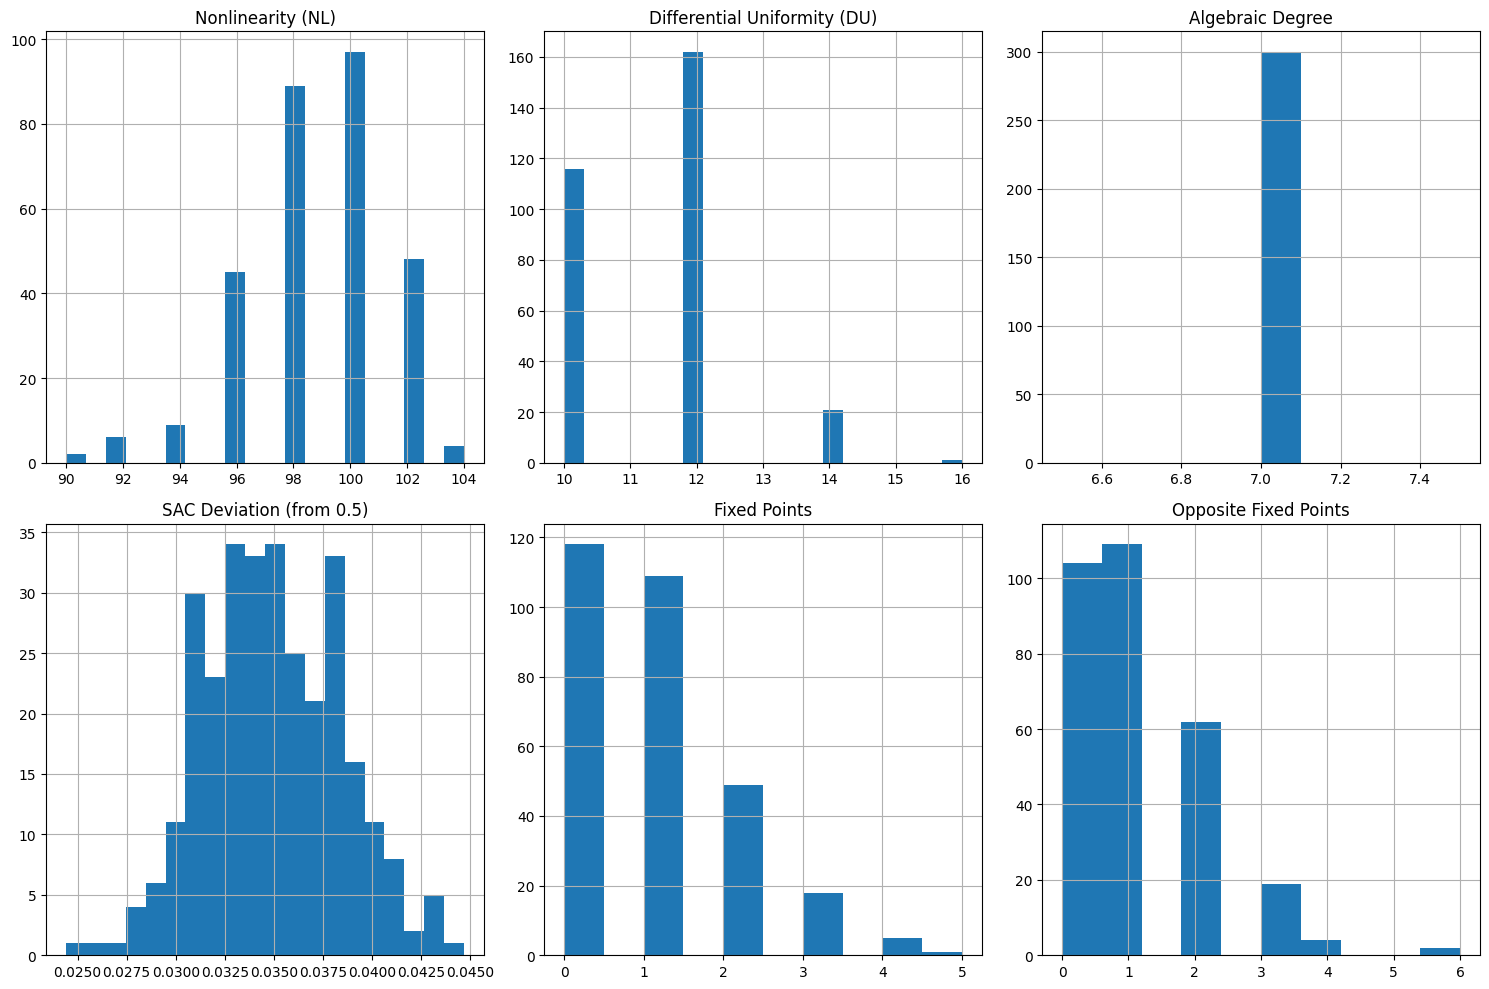

Baseline Statistics:
               NL          DU  Degree     SAC_Dev  Fixed_Points  \
count  300.000000  300.000000   300.0  300.000000    300.000000   
mean    98.773333   11.380000     7.0    0.034924      0.953333   
std      2.445791    1.224991     0.0    0.003473      1.000580   
min     90.000000   10.000000     7.0    0.024414      0.000000   
25%     98.000000   10.000000     7.0    0.032471      0.000000   
50%     98.000000   12.000000     7.0    0.034668      1.000000   
75%    100.000000   12.000000     7.0    0.037598      1.000000   
max    104.000000   16.000000     7.0    0.044678      5.000000   

       Opposite_Fixed_Points  
count             300.000000  
mean                1.060000  
std                 1.045647  
min                 0.000000  
25%                 0.000000  
50%                 1.000000  
75%                 2.000000  
max                 6.000000  


In [73]:
# Generate 300 random S-boxes
baseline_samples = 300
baseline_data = []

print(f"Generating and evaluating {baseline_samples} random S-boxes...")

for _ in range(baseline_samples):
    sbox = random_sbox()
    nl = nonlinearity(sbox)
    du = differential_uniformity(sbox) 
    deg = algebraic_degree(sbox)
    sac = sac_metrics(sbox)
    sac_dev = np.mean(np.abs(sac - 0.5)) # SAC deviation from 0.5
    fp, ofp = count_fixed_points(sbox)
    
    baseline_data.append({
        'NL': nl,
        'DU': du,
        'Degree': deg,
        'SAC_Dev': sac_dev,
        'Fixed_Points': fp,
        'Opposite_Fixed_Points': ofp
    })

baseline_df = pd.DataFrame(baseline_data)

# Plot distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
baseline_df['NL'].hist(ax=axes[0, 0], bins=20)
axes[0, 0].set_title('Nonlinearity (NL)')

baseline_df['DU'].hist(ax=axes[0, 1], bins=20)
axes[0, 1].set_title('Differential Uniformity (DU)')

baseline_df['Degree'].hist(ax=axes[0, 2], bins=10)
axes[0, 2].set_title('Algebraic Degree')

baseline_df['SAC_Dev'].hist(ax=axes[1, 0], bins=20)
axes[1, 0].set_title('SAC Deviation (from 0.5)')

baseline_df['Fixed_Points'].hist(ax=axes[1, 1], bins=10)
axes[1, 1].set_title('Fixed Points')

baseline_df['Opposite_Fixed_Points'].hist(ax=axes[1, 2], bins=10)
axes[1, 2].set_title('Opposite Fixed Points')

plt.tight_layout()
plt.show()

print("Baseline Statistics:")
print(baseline_df.describe())

# 4. Define a fitness function that combines the metrics
We define a fitness function that:
- Prioritises minimum nonlinearity (target 112)
- Penalises high DU (especially > 4)
- Rewards higher algebraic degree
- Penalises fixed and opposite fixed points
- Penalises deviations of SAC from 0.5

In [74]:
def swap(individual, i_j):
    i,j = i_j
    temp = individual[i]
    individual[i] = individual[j]
    individual[j] = temp
    return individual

def mutate(individual):
    n = len(individual)
    i = np.random.randint(n)
    j = (np.random.randint(n) + i - 1)%n
    swap(individual,(i,j))
    return individual,

def evaluate(individual):
    # Convert individual to numpy array for metric calculations
    sbox = np.array(individual, dtype=np.uint8)
    
    # Calculate metrics
    nl = nonlinearity(sbox)
    du = differential_uniformity(sbox)
    fp, ofp = count_fixed_points(sbox)
    
    # Store metrics in individual for logging
    individual.nl = nl
    individual.du = du
    individual.fp = fp
    individual.ofp = ofp
    
    # Fitness function design:
    # 1. Maximize Nonlinearity (Target 112)
    # 2. Minimize Differential Uniformity (Target <= 4)
    # 3. Minimize Fixed Points (Target 0)
    
    # Weighted sum approach
    # We give high weight to NL to prioritize it.
    # We subtract DU and FP to penalize them.
    
    fitness = (nl * 10) - du - (fp + ofp)
    
    return fitness,

# 5. Choose a search method
We choose an Evolutionary Algorithm (EA).
- Representation: Permutation of 0...255 (list of integers).
- Variation operators:
    - Mutation: Swap two elements.
    - Crossover: Uniform Partially Matched Crossover (UPMX).
- Selection strategy: Tournament selection (size 3).

In [75]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, random_sbox)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxUniformPartialyMatched, indpb=0.4)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=50)
hof = tools.HallOfFame(1)

# Use MultiStatistics to track multiple metrics
stats_fit = tools.Statistics(key=lambda ind: ind.fitness.values)
stats_nl = tools.Statistics(key=lambda ind: ind.nl)
stats_du = tools.Statistics(key=lambda ind: ind.du)
stats_fp = tools.Statistics(key=lambda ind: ind.fp)
stats_ofp = tools.Statistics(key=lambda ind: ind.ofp)

stats = tools.MultiStatistics(fitness=stats_fit, nl=stats_nl, du=stats_du, fp=stats_fp, ofp=stats_ofp)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("std", np.std)

/home/adam/studies/9sem/crypto3/.venv/lib/python3.13/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/adam/studies/9sem/crypto3/.venv/lib/python3.13/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


# 6. Run experiments
We run the EA starting from random S-boxes for a fixed evaluation budget.
We track the best-so-far metrics.
We also compare against baselines (Random Search, Hill Climbing).
## Evolutionary Algorithm

In [76]:
ea_final_pop, ea_log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=30, stats=stats, halloffame=hof, verbose=True)

   	      	                       du                      	                   fitness                    	                       fp                      	                       nl                      	                      ofp                       
   	      	-----------------------------------------------	----------------------------------------------	-----------------------------------------------	-----------------------------------------------	------------------------------------------------
gen	nevals	avg  	gen	max	min	nevals	std    	avg   	gen	max 	min	nevals	std   	avg 	gen	max	min	nevals	std    	avg  	gen	max	min	nevals	std    	avg 	gen	max	min	nevals	std     
0  	50    	11.16	0  	14 	10 	50    	1.20599	981.38	0  	1027	927	50    	23.218	0.78	0  	4  	0  	50    	1.00578	99.44	0  	104	94 	50    	2.29922	1.08	0  	3  	0  	50    	0.913017
1  	25    	11.2 	1  	14 	10 	25    	1.13137	994.52	1  	1027	930	25    	19.543	0.38	1  	3  	0  	25    	0.66   	100.68	1  	104	94 	25    	1.9436 	0.

## Hill climbing (local search)

In [77]:
def localSearch(individual, toolbox, iter_limit=None, stats=None, halloffame=None, verbose=True):
    population = [individual]
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    gen = 1
    while True:
        improvement = False 
        nevals = 0
        for move in toolbox.neighbors(individual):
            new_individual = toolbox.clone(individual)
            new_individual = toolbox.apply_move(new_individual, move)
            fitness = toolbox.evaluate(new_individual)
            nevals += 1
            new_individual.fitness.values = fitness
            if fitness[0] > individual.fitness.values[0]:
                improvement = True
                break
            if iter_limit is not None and nevals >= iter_limit: # 256 choose 2 is around 32k, which would cause the algorithm to run for like half an hour
                break
        
        if improvement:
            individual = new_individual

        if halloffame is not None:
            halloffame.update([individual])
        
        record = stats.compile([individual]) if stats else {}
        logbook.record(gen=gen, nevals=nevals, **record)
        if verbose:
            print(logbook.stream)
        gen += 1
        
        if not improvement:
            break

    return individual, logbook

In [78]:
def neighbours(*_):
    pairs = list(combinations(range(256),2))
    random.shuffle(pairs)
    return pairs

toolbox.register("neighbors", neighbours)
toolbox.register("apply_move", swap)

ITER_LIMIT = 1000
final_ind, ls_log = localSearch(toolbox.individual(), toolbox, iter_limit=ITER_LIMIT, stats=stats, verbose=True)

   	      	                     du                    	                  fitness                  	                     fp                    	                     nl                    	                    ofp                    
   	      	-------------------------------------------	-------------------------------------------	-------------------------------------------	-------------------------------------------	-------------------------------------------
gen	nevals	avg	gen	max	min	nevals	std	avg	gen	max	min	nevals	std	avg	gen	max	min	nevals	std	avg	gen	max	min	nevals	std	avg	gen	max	min	nevals	std
0  	1     	10 	0  	10 	10 	1     	0  	989	0  	989	989	1     	0  	1  	0  	1  	1  	1     	0  	100	0  	100	100	1     	0  	0  	0  	0  	0  	1     	0  
1  	7     	12 	1  	12 	12 	7     	0  	1007	1  	1007	1007	7     	0  	1  	1  	1  	1  	7     	0  	102	1  	102	102	7     	0  	0  	1  	0  	0  	7     	0  
1  	7     	12 	1  	12 	12 	7     	0  	1007	1  	1007	1007	7     	0  	1  	1  	1  	1  	7     	0  	10

## Random search

In [79]:
def random_search(samples, toolbox, stats=None, halloffame=None, verbose=True):
    population = toolbox.population(samples)
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    return population, logbook

In [80]:
evaluated_sample, rs_log = random_search(ITER_LIMIT,toolbox,stats)

   	      	                       du                      	                    fitness                    	                       fp                      	                       nl                      	                      ofp                      
   	      	-----------------------------------------------	-----------------------------------------------	-----------------------------------------------	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max	min	nevals	std    	avg    	gen	max 	min	nevals	std    	avg  	gen	max	min	nevals	std    	avg   	gen	max	min	nevals	std    	avg  	gen	max	min	nevals	std    
0  	1000  	11.344	0  	16 	10 	1000  	1.22379	976.999	0  	1030	885	1000  	25.4938	1.009	0  	6  	0  	1000  	1.02123	99.038	0  	104	90 	1000  	2.54687	1.028	0  	6  	0  	1000  	1.01647


# 7. Analyse results
We show convergence plots and present the best S-box found.
We compare the results to the baseline distributions.

In [87]:
def get_metrics(ind, name="Method"):
    # Convert to numpy array if it's not already
    sbox = np.array(ind, dtype=np.uint8)
    
    nl = nonlinearity(sbox)
    du = differential_uniformity(sbox)
    fp, ofp = count_fixed_points(sbox)
    deg = algebraic_degree(sbox)
    sac = sac_metrics(sbox)
    sac_mean = np.mean(sac)
    bic = bic_metrics(sbox)
    
    return {
        "Method": name,
        "Nonlinearity": nl,
        "Diff. Uniformity": du,
        "Fixed Points": fp,
        "Opp. Fixed Points": ofp,
        "Alg. Degree": deg,
        "SAC Mean": sac_mean,
        "BIC Score": bic
    }


In [82]:
def plot_log(log):
    # Check if we have chapters (MultiStatistics)
    if hasattr(log, "chapters") and len(log.chapters) > 0:
        chapters = [key for key in log.chapters]
        fig, axes = plt.subplots(len(chapters), 1, figsize=(10, 3*len(chapters)), sharex=True)
        if len(chapters) == 1:
            axes = [axes]
            
        # Try to get evaluations count, fallback to generation index
        if "nevals" in log[0]:
            evals = np.cumsum(log.select("nevals"))
            x_label = "Evaluations"
        else:
            evals = range(len(log))
            x_label = "Generation"
        
        for i, chapter in enumerate(chapters):
            ax = axes[i]
            # Access the chapter data (list of dicts)
            chapter_log = log.chapters[chapter]
            
            avg_ = [d['avg'] for d in chapter_log]
            min_ = [d['min'] for d in chapter_log]
            max_ = [d['max'] for d in chapter_log]
            
            # Handle tuple values (e.g. fitness)
            if isinstance(avg_[0], (tuple, np.ndarray)) and np.size(avg_[0]) == 1:
                avg_ = [np.item(x) for x in avg_]
                min_ = [np.item(x) for x in min_]
                max_ = [np.item(x) for x in max_]

            ax.plot(evals, avg_, label="avg")
            ax.plot(evals, max_, label="max")
            ax.plot(evals, min_, label="min")
            
            # Optional: Fill between if std is available and scalar
            if 'std' in chapter_log[0]:
                std_ = [d['std'] for d in chapter_log]
                if isinstance(std_[0], (tuple, np.ndarray)) and np.size(std_[0]) == 1:
                    std_ = [np.item(x) for x in std_]
                
                # Ensure all are numeric lists
                try:
                    avg_np = np.array(avg_)
                    std_np = np.array(std_)
                    min_np = np.array(min_)
                    max_np = np.array(max_)
                    ax.fill_between(evals, 
                                    np.clip(avg_np - std_np, a_min=min_np, a_max=None), 
                                    np.clip(avg_np + std_np, a_min=None, a_max=max_np), 
                                    alpha=0.2)
                except:
                    pass # Skip fill_between if data types are incompatible

            ax.set_ylabel(chapter)
            ax.legend()
            ax.grid(True)
            
        axes[-1].set_xlabel(x_label)
        plt.tight_layout()
        return fig
    else:
        # Fallback for simple statistics
        min_ = log.select("min")
        max_ = log.select("max")
        avg_ = log.select("avg")
        std_ = log.select("std")
        evals = np.cumsum(log.select("nevals"))
        plt.plot(evals, avg_, label="avg")
        plt.plot(evals, max_, label="max")
        plt.plot(evals, min_, label="min")
        plt.fill_between(evals, np.clip(np.array(avg_)-np.array(std_),min=min_), np.clip(np.array(avg_)+np.array(std_),max=max_), alpha=0.2)
        plt.legend()
        plt.xlabel("Evaluations")
        plt.ylabel("Fitness")
        return plt.gcf()

## Results of the Evolutionary Algorithm

In [88]:
# Best S-box from EA
best_ea_ind = hof[0]
ea_metrics = get_metrics(best_ea_ind, "Evolutionary Algo")

print("Best S-box metrics (EA):")
for k, v in ea_metrics.items():
    print(f"{k}: {v}")

Best S-box metrics (EA):
Method: Evolutionary Algo
Nonlinearity: 106.0
Diff. Uniformity: 10
Fixed Points: 0
Opp. Fixed Points: 0
Alg. Degree: 7
SAC Mean: 0.498779296875
BIC Score: 0.07071496911917573


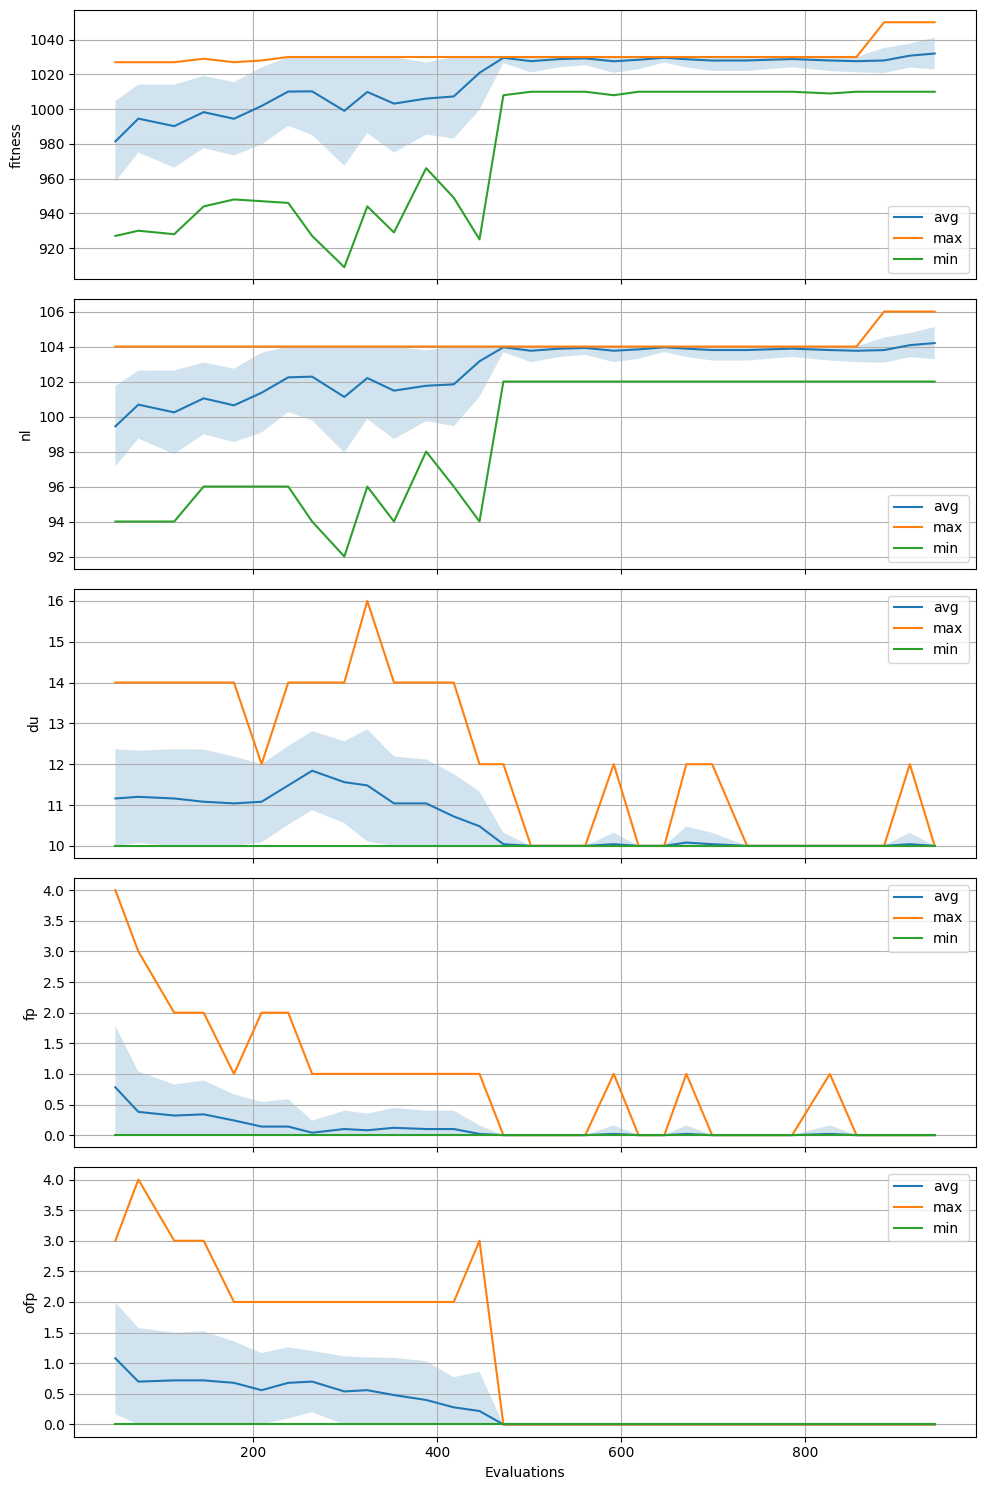

In [83]:
plot_log(ea_log)
plt.show()

## Results of the Hill Climbing

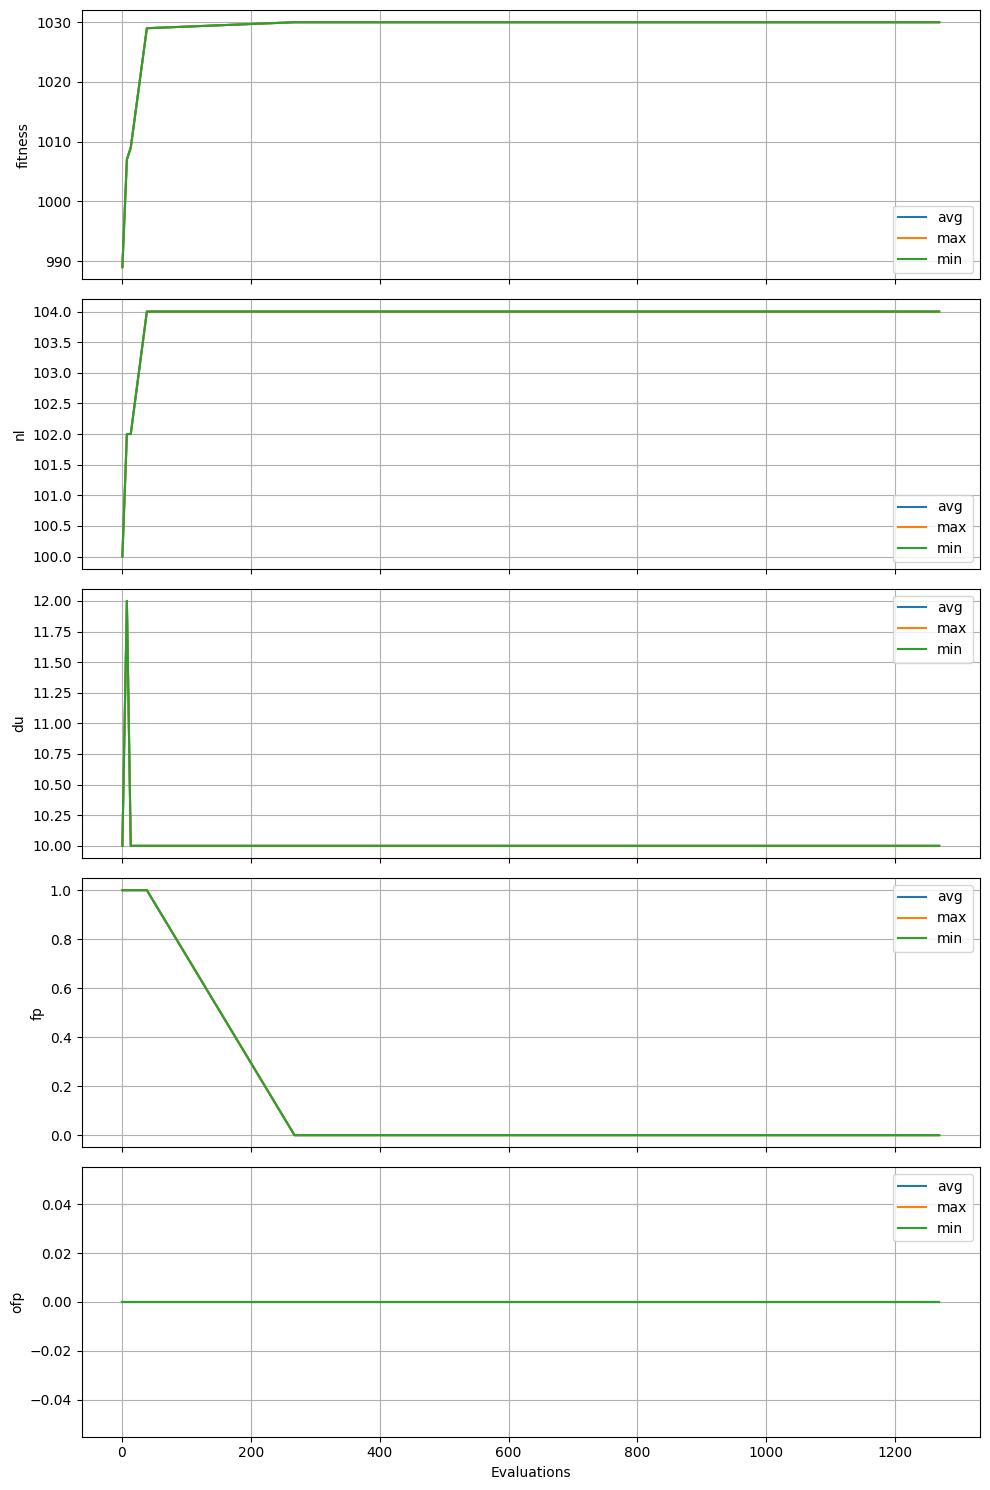

In [84]:
plot_log(ls_log)
plt.show()

In [85]:
# Best S-box from Local Search
ls_metrics = get_metrics(final_ind, "Local Search")

print("Best S-box metrics (Local Search):")
for k, v in ls_metrics.items():
    print(f"{k}: {v}")

Best S-box metrics (Local Search):
Method: Local Search
Nonlinearity: 104.0
Diff. Uniformity: 10
Fixed Points: 0
Opp. Fixed Points: 0
Alg. Degree: 7
SAC Mean: 0.50146484375
BIC Score: 0.07261754570806812


## Results of the random search

In [89]:
best_rs_ind = tools.selBest(evaluated_sample, 1)[0]
rs_metrics = get_metrics(best_rs_ind, "Random Search")

print("Best S-box metrics (Random Search):")
for k, v in rs_metrics.items():
    print(f"{k}: {v}")


Best S-box metrics (Random Search):
Method: Random Search
Nonlinearity: 104.0
Diff. Uniformity: 10
Fixed Points: 0
Opp. Fixed Points: 0
Alg. Degree: 7
SAC Mean: 0.50146484375
BIC Score: 0.06753709654014721


## Final results in the table

In [94]:
results_df = pd.DataFrame([ea_metrics, ls_metrics, rs_metrics])
cols = ["Method", "Nonlinearity", "Diff. Uniformity", "Fixed Points", "Opp. Fixed Points", "Alg. Degree", "SAC Mean", "BIC Score"]
results_df = results_df[cols]
results_df_transposed = results_df.set_index('Method').T
display(results_df_transposed)

Method,Evolutionary Algo,Local Search,Random Search
Nonlinearity,106.000000,104.000000,104.000000
Diff. Uniformity,10.000000,10.000000,10.000000
Fixed Points,0.000000,0.000000,0.000000
Opp. Fixed Points,0.000000,0.000000,0.000000
Alg. Degree,7.000000,7.000000,7.000000
SAC Mean,0.498779,0.501465,0.501465
BIC Score,0.070715,0.072618,0.067537


# 8. Write a short report
- Problem description
- Definitions of metrics
- Description of fitness design and search method
- Baseline vs. your method
- Discussion: trade-offs, difficulties, future work

## Problem Description
The goal is to find 8x8 S-boxes (permutations of 0..255) that have high cryptographic strength. Key metrics include Nonlinearity (target 112), Differential Uniformity (target <= 4), and others like SAC, BIC, and Algebraic Degree.

## Metrics
- **Nonlinearity**: Measures distance from affine functions. Higher is better.
- **Differential Uniformity**: Measures resistance to differential cryptanalysis. Lower is better.
- **SAC**: Strict Avalanche Criterion. Flipping one input bit should change output bits with prob 0.5.
- **BIC**: Bit Independence Criterion. Output bits should change independently.
- **Fixed Points**: Inputs mapping to themselves (or bitwise complement). Should be 0.

## Method
We used an Evolutionary Algorithm with:
- **Representation**: Permutation of 256 bytes.
- **Fitness**: Weighted sum prioritizing Nonlinearity, then penalizing DU and Fixed Points.
- **Operators**: Swap mutation, UPMX crossover.

## Results
(Fill in after running experiments)

## Discussion
(Fill in after running experiments)